In [1]:
import gym
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model

from IPython.display import clear_output
from tensorflow.keras.models import load_model

In [2]:
class ReplayBuffer():
    def __init__(self, maxsize, statedim, naction):
        self.cnt = 0
        self.maxsize = maxsize
        self.state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.action_memory = np.zeros((maxsize, naction), dtype=np.float32)
        self.reward_memory = np.zeros((maxsize,), dtype=np.float32)
        self.next_state_memory = np.zeros((maxsize, *statedim), dtype=np.float32)
        self.done_memory = np.zeros((maxsize,), dtype= np.bool)

    def storexp(self, state, action, reward, next_state, done):
        index = self.cnt % self.maxsize
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.done_memory[index] = 1- int(done)
        self.cnt += 1

    def sample(self, batch_size):
        max_mem = min(self.cnt, self.maxsize)
        batch = np.random.choice(max_mem, batch_size, replace= False)  
        states = self.state_memory[batch]
        next_states = self.next_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        dones = self.done_memory[batch]
        return states, next_states, rewards, actions, dones


In [3]:
class Actor(Model):
    def __init__(self, state_size: int, action_size: int, 
    ):
        """Initialization."""
        super(Actor, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        # set the hidden layers
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.policy =  tf.keras.layers.Dense(action_size, activation='tanh')

    def call(self, state):
        layer1 = self.layer1(state)
        layer2 = self.layer2(layer1)
        policy = self.policy(layer2)
        return policy

In [4]:
class CriticQ(Model):
    def __init__(
        self, 
        state_size: int, 
    ):
        """Initialize."""
        super(CriticQ, self).__init__()
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.value = tf.keras.layers.Dense(1, activation = None)

    def call(self, state, action):
        layer1 = self.layer1(tf.concat([state, action], axis=1))
        layer2 = self.layer2(layer1)
        value = self.value(layer2)
        return value


In [5]:
class Agent():
    """
        
    Attributes:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (tf.keras.Model): target actor model to select actions
        critic (tf.keras.Model): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self, 
        env: gym.Env,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            gamma (float): discount factor
        """
        
        # CREATING THE Q-Network
        self.env = env
        
        self.state_size = self.env.observation_space.shape
        self.action_size = len(env.action_space.high)
        
        self.actor_lr = 7e-3
        self.critic_lr = 7e-3
        self.gamma = 0.99    # discount rate
        self.actor = Actor(self.state_size, self.action_size
                          )
        self.actor_target = Actor(self.state_size, self.action_size
                          )
        self.critic = CriticQ(self.state_size
                          )
        self.critic_target = CriticQ(self.state_size
                          )
        self.batch_size = 64
        # self.a_opt = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
        # self.c_opt = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
        self.a_opt = tf.keras.optimizers.Adam(learning_rate=self.actor_lr)
        self.c_opt = tf.keras.optimizers.Adam(learning_rate=self.critic_lr)
        self.memory = ReplayBuffer(1_00_000, env.observation_space.shape, len(env.action_space.high))
        self.trainstep = 0
        self.update_freq = 5
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]
        self.update_target()
    
    def get_action(self, state, evaluate=False):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.action_size], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        # print(actions)
        return actions[0]
    
    def savexp(self,state, next_state, action, done, reward):
        self.memory.storexp(state, next_state, action, done, reward)

    def update_target(self):
        self.actor_target.set_weights(self.actor.get_weights())
        self.critic_target.set_weights(self.critic.get_weights())

    def train_step(self):
        if self.memory.cnt < self.batch_size:
            return 

        states, next_states, rewards, actions, dones = self.memory.sample(self.batch_size)

        states      = tf.convert_to_tensor(states, dtype= tf.float32)
        actions     = tf.convert_to_tensor(actions, dtype= tf.float32)
        rewards     = tf.convert_to_tensor(rewards, dtype= tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
        # dones       = tf.convert_to_tensor(dones, dtype= tf.bool)
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            curr_Ps = self.actor(states)
            curr_Qs = tf.squeeze(self.critic(states, actions), 1)
            next_P_targs = self.actor_target(next_states)
            next_Q_targs = tf.squeeze(self.critic_target(next_states, next_P_targs), 1)
            expected_Qs  = rewards + self.gamma * next_Q_targs * dones
            
            # critic loss
            critic_loss = tf.keras.losses.MSE(expected_Qs, curr_Qs)
            
            actor_loss = -self.critic(states, curr_Ps)
            actor_loss = tf.math.reduce_mean(actor_loss)
            
        actorGrads = tape1.gradient(actor_loss,  self.actor.trainable_variables)
        criticGrads = tape2.gradient(critic_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(actorGrads, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(criticGrads, self.critic.trainable_variables))
        
        self.trainstep +=1
        if self.trainstep % self.update_freq == 0:
            self.update_target()


In [6]:
seed = 1234
# CREATING THE ENVIRONMENT
env_name = "CliffWalking-v0"
env = gym.make(env_name)
# env.seed(seed)     # reproducible, general Policy gradient has high variance
# state_low   = env.observation_space.low
# state_high  = env.observation_space.high
# action_low  = env.action_space.low 
# action_high = env.action_space.high
# print("state_low   :", state_low)
# print("state_high  :", state_high)
# print("action_low  :", action_low)
# print("action_high :", action_high)

state_low   : [-inf -inf -inf -inf -inf -inf -inf -inf]
state_high  : [inf inf inf inf inf inf inf inf]
action_low  : [-1. -1.]
action_high : [1. 1.]


In [7]:
# INITIALIZING THE Q-PARAMETERS
hidden_size = 512
max_episodes = 5  # Set total number of episodes to train agent on.

In [8]:
# train
agent = Agent(
    env, 
#     memory_size, 
#     batch_size, 
#     epsilon_decay,
)

if __name__ == "__main__":
    tf.random.set_seed(336699)
    # TRAINING LOOP
    #List to contain all the rewards of all the episodes given to the agent
    scores = []
    reward_records = []
    
    # EACH EPISODE    
    for episode in range(max_episodes):
        ## Reset environment and get first new observation
        state = agent.env.reset()
        episode_reward = 0
        done = False  # has the enviroment finished?
        
            
        # EACH TIME STEP    
        while not done:
        # for step in range(max_steps):  # step index, maximum step is 200
            action = agent.get_action(state)
            
            # TAKING ACTION
            next_state, reward, done, _ = agent.env.step(action)
            
            agent.savexp(state, action, reward, next_state, done)
            agent.train_step()
            
            # Our new state is state
            state = next_state
            
            episode_reward += reward

            # if episode ends
            if done:
                scores.append(episode_reward)
                print("Episode " + str(episode+1) + ": " + str(episode_reward))
                reward_records.append(episode_reward)
                
                break

episode_reward = 0
state = env.reset()
while not done:
    action = agent.act(state, True)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    episode_reward += reward
    if done:
        print(episode_reward)


C:\Users\Maria\AppData\Local\Temp\ipykernel_14952\324145003.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.done_memory = np.zeros((maxsize,), dtype= np.bool)


Episode 1: -167.77408271181105
Episode 2: -446.0926921972597
Episode 3: -427.0779552921326
Episode 4: -731.5235531718549
Episode 5: -1458.582238346411


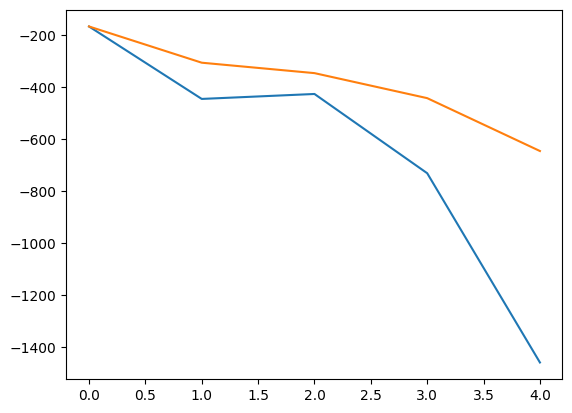

In [9]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)